# Development notebook for processing sexual dimorphism data
## This notebook takes as input the csv produced from 'sample_reader_nb', which represents the load and rearranged sexual dimorphism data matrix

In [16]:
# Isaac Berez
# 17.01.23
import sys
from scipy.io import mmread
import os
import glob
import pandas as pd
import numpy as np
from pandas_ods_reader import read_ods
from copy import deepcopy
import pprint
import json
import re
from datetime import datetime
import logging
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor

import dimorph_processing as dp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Read in meta data and big data file, create meta_data_df, and remove cntnp strain

In [2]:
meta_data_df, dimorph_df, dimorph_df_bool = dp.load_data(metadata_file = '/bigdata/isaac/meta_data_dict_040224.json', 
                                                         bigdata_file = '/bigdata/isaac/dimorph_df.feather')

In [3]:
dimorph_df.shape

(27933, 79613)

In [4]:
meta_data_df.shape

(27, 79613)

#### create boolean version of gene expression data frame, used in level 2 and level 3 filtering

In [5]:
# create boolean version of the dataframe, where any expression >0 = 1,
# used to calculate total genes/cell
#dimorph_df_bool = dimorph_df.mask(dimorph_df>0, other = 1)
dimorph_df_bool.head()

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCAAGTACTGTC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCAGTAACATAG-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,...,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGAGTGCTCGC-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2,TTTGTTGTCGAAGGAC-1_10X37_2,TTTGTTGTCTCTGCTG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,0,1,0,1,0,0,1,1,1,0,...,1,0,1,0,1,1,1,0,0,0
0610009B22Rik,0,0,0,1,0,1,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
0610009L18Rik,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0
0610009O20Rik,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610010F05Rik,0,0,1,0,0,0,1,1,1,0,...,1,0,1,0,1,0,1,0,0,0


### 2. Calculate molecules/cell and genes/cell vectors, keep only cells with >2500 mol/cell and >2000 genes/cell

In [6]:
dimorph_df_l2, dimorph_df_bool_l2, meta_data_df_l2 = dp.cell_exclusion(threshold_m = 2500, 
                                                      threshold_g = 2000,
                                                      df_bool = dimorph_df_bool,
                                                      meta_data_df = meta_data_df,
                                                      df = dimorph_df)
dimorph_df_l2.head()

Total cells reduced from 79613 to 43492


,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,AAACGAAGTGACCTGC-1_10X51_2,AAACGCTAGCTCACTA-1_10X51_2,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,0,2,2,0,1,3,2,0,1,1,...,0,1,1,1,0,1,2,1,1,0
0610009B22Rik,0,0,1,2,2,0,1,0,0,0,...,1,0,0,0,0,0,2,0,0,0
0610009L18Rik,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
0610009O20Rik,1,0,0,1,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
0610010F05Rik,0,0,0,0,2,1,1,0,0,0,...,1,0,0,1,0,2,1,0,1,0


In [7]:
dimorph_df_l2.shape

(27933, 43492)

### 3. Gene Exclusion - Keep only genes expressed in >10 cells, <50% of all cells

In [8]:
dimorph_df_l3, dimorph_df_bool_l3, meta_data_df_l3 = dp.gene_exclusion(num_cell_lwr_bound=10,
                                                      percent_cell_upper_bound=50,
                                                     df_bool=dimorph_df_bool_l2,
                                                     df = dimorph_df_l2,
                                                     meta_data_df = meta_data_df_l2)
dimorph_df_l3.head()

Total genes reduced from 27933 to 17081


,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,AAACGAAGTGACCTGC-1_10X51_2,AAACGCTAGCTCACTA-1_10X51_2,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,0,2,2,0,1,3,2,0,1,1,...,0,1,1,1,0,1,2,1,1,0
0610009B22Rik,0,0,1,2,2,0,1,0,0,0,...,1,0,0,0,0,0,2,0,0,0
0610009L18Rik,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
0610009O20Rik,1,0,0,1,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
0610010F05Rik,0,0,0,0,2,1,1,0,0,0,...,1,0,0,1,0,2,1,0,1,0


In [9]:
dimorph_df_l3.shape

(17081, 43492)

#### Sanity Check if known sex specific genes in dimorph_df_l2

In [10]:
print ('Xist' in dimorph_df_l2.index)
print ('Tsix' in dimorph_df_l2.index)
print ('Ddx3y' in dimorph_df_l2.index)
print ('Eif2s3y' in dimorph_df_l2.index)
print ('Kdm5d' in dimorph_df_l2.index)
print ('Uty' in dimorph_df_l2.index)

True
True
True
True
True
True


num m cells: 19749 num f cells: 23743


<IPython.core.display.Javascript object>


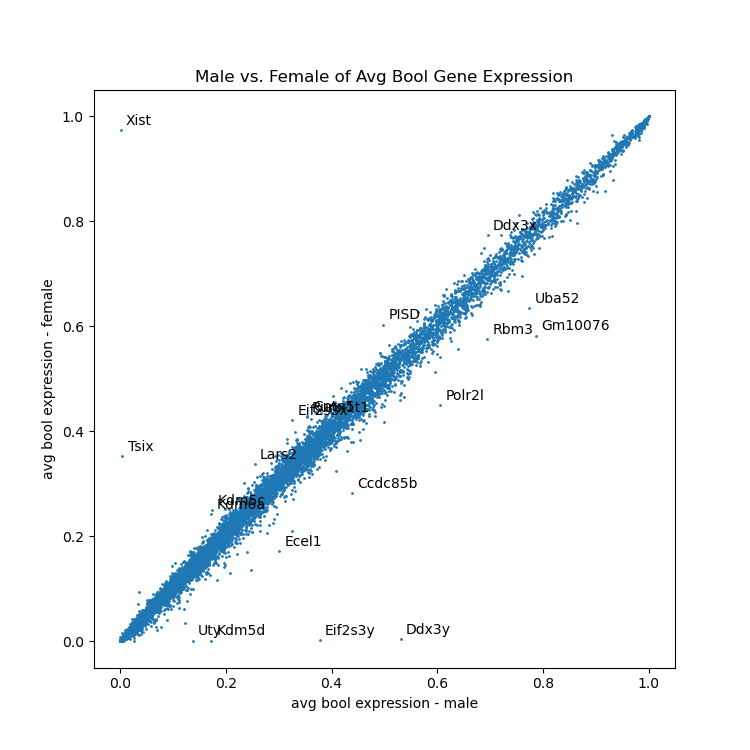

In [11]:
%matplotlib notebook
avg_bool_mf_df_sorted_l2 = dp.avg_bool_gene_expression_by_sex(df_bool = dimorph_df_bool_l2,
                                                              meta_data_df=meta_data_df_l2,
                                                             num_top_genes=10,
                                                             plot_flag=1)

### 4. CV vs. Mean (Poisson filter)

<IPython.core.display.Javascript object>


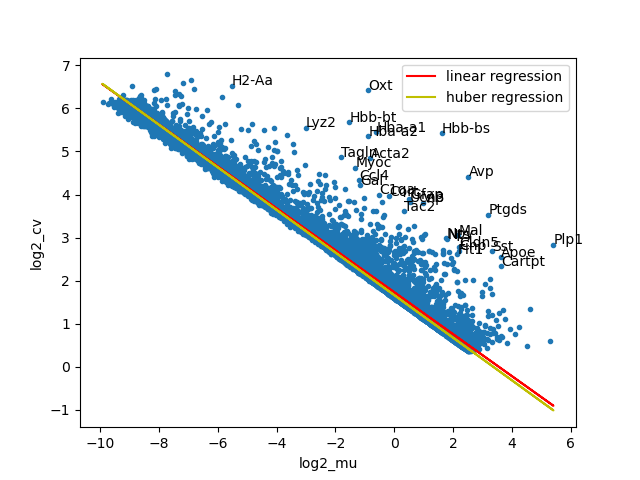

In [19]:
cv_df = dp.analyze_cv(df = dimorph_df_l3,norm_scale_factor=20000,num_top_genes=30,plot_flag=1)

In [20]:
cv_df.head()

,log2mu,log2cv,delta
gene,,,
Hbb-bs,1.620289,5.429946,4.491182
Oxt,-0.879842,6.428204,4.270500
Avp,2.526425,4.414903,3.917926
Plp1,5.415903,2.831623,3.743413
Hba-a1,-0.615138,5.448019,3.419372
